# Building Network graph from ArcGIS shapefile
This notebook builds a network from an ARCGIS shapefile and it matches the origin destinations of Block groups to their job destination using closest node in the database

In [ ]:
# install packages, set correct path
Load=True #if loading, we do not read from shp files. we read from pickle for speed
path='/content/drive/My Drive/GIS' #Your path
#path='/content/drive/My Drive/Pavement/GIS/' #Egemen Path
from google.colab import drive
drive.mount('/content/drive')
import sys
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
os.chdir(path)
!pip install osmnx
!pip install networkx
!pip install rtree
import osmnx as ox
import networkx as nx
import pickle
from shapely.geometry import LineString, Point,MultiLineString

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.3 MB/s eta 0:00:00


Reading the road, EJ communities and Census Blocks from shapefile. might take a while

In [ ]:
if Load:
  road=pd.read_pickle('pickle/world.pkl')
  CensusBlocks=pd.read_pickle('pickle/CensusBlocks.pkl')
  EJ=pd.read_pickle('pickle/EJ.pkl')
  LODES=pd.read_pickle('pickle/LODES.pkl')
  NodeMatch=pd.read_pickle('pickle/NodeMatch.pkl')

else:
  road = gpd.read_file('Shapes/Pavement Condition/Pavement_Condition_2020.shp')
  CensusBlocks=gpd.read_file('Shapes/Census Blocks/CENSUS2020BLOCKS_POLY.shp')
  CensusBlocks['GEOID20']=CensusBlocks['GEOID20'].astype(str).astype(int)
  CensusBlocks["centroid"]=CensusBlocks["geometry"].centroid.to_crs(epsg=4326)
  EJ=gpd.read_file('Shapes/EJ Data/EJ_POLY.shp')
  LODES=pd.read_csv('LODES_data.csv')
  NodeMatch = gpd.read_file('Shapes/Matched Blocks/NearBlocks.shp')
  NodeMatch.GEOID20=NodeMatch.GEOID20.astype(str).astype(int)

In [ ]:
#Convert to 4236 coordinate system
print(road.crs)
print(CensusBlocks.crs)
print(EJ.crs)
CensusBlocks = CensusBlocks.to_crs(4326)
road = road.to_crs(4326)
EJ = EJ.to_crs(4326)

EPSG:4326
EPSG:4326
EPSG:4326


<Axes: >

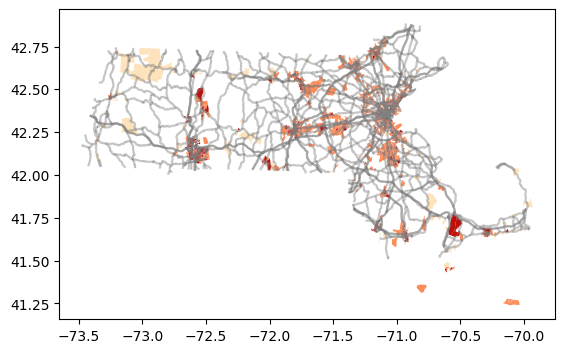

In [ ]:
fig, ax = plt.subplots()
# Plot the roads and EJ communities
road.plot(ax=ax, color='gray', alpha=0.5)
EJ.plot(ax=ax,column='EJ_CRITERI',cmap='OrRd')

Save as pickle file for later use

In [ ]:
if Load==False:
  road.to_pickle('pickle/world.pkl')
  CensusBlocks.to_pickle('pickle/CensusBlocks.pkl')
  EJ.to_pickle('pickle/EJ.pkl')
  LODES.to_pickle('pickle/LODES.pkl')
  NodeMatch.to_pickle('pickle/NodeMatch.pkl')


# Building Network graph
first we load the nodes and edges and convert them to a graph. Currently, we are not restricting directionality of road network (which is incorrect), we are also calculating the shortest path between nodes based on distance only (not considering speed limit)

I Route System Speed Limits - Mean:  61.69299376746185 , Std:  6.366066366920164
N Route System Speed Limits - Mean:  32.32483416252073 , Std:  10.15065843445545
US Route System Speed Limits - Mean:  43.73623348017621 , Std:  9.066649532171663
SR Route System Speed Limits - Mean:  39.27298680589491 , Std:  9.767772287684084

In [ ]:
if Load:
  with open('pickle/G.gpickle', 'rb') as f:
    G = pickle.load(f)
  nodes=pd.read_pickle('pickle/nodes.pkl')
  edges=pd.read_pickle('pickle/edges.pkl')
else:
  nodes=gpd.read_file('Shapes/Graph/Nodes and Edges/Network4/Nodes.shp')
  edges=gpd.read_file('Shapes/Graph/Nodes and Edges/Network4/test.shp')
  #edges.loc[(edges['Speed_Lim'] == 0) & (edges['Route_Syst'] == 'I'), 'Speed_Lim'] = 65
  #edges.loc[(edges['Speed_Lim'] == 0) & (edges['Route_Syst'] == 'N'), 'Speed_Lim'] = 30
  #edges.loc[(edges['Speed_Lim'] == 0) & (edges['Route_Syst'] == 'US'), 'Speed_Lim'] = 45
  #edges.loc[(edges['Speed_Lim'] == 0) & (edges['Route_Syst'] == 'SR'), 'Speed_Lim'] = 40
  edges.drop(columns=['Length'],inplace=True)
  edges.rename(columns={'Length2': 'Length'}, inplace=True)
  edges['Length'] = edges['Length']/1.35
  edges['length'] = edges['Length']
  edges['time']=edges['Length']/(edges.Speed_Lim*0.000277778+0.000001) #to miles per second
  nodes['x'] = nodes.geometry.x
  nodes['y'] = nodes.geometry.y
  edges.set_index(['Min_ID', 'Max_ID', edges.groupby(['Min_ID', 'Max_ID']).cumcount()], inplace=True)

  G=ox.graph_from_gdfs(nodes,edges)
  G = G.to_undirected()
  # First, we define a new edge attribute `time` for each edge in the graph, which is the length of the edge divided by the speed limit
  #for u, v, k, data in G.edges(data=True, keys=True):
  #    data['time'] = data['length'] / (data['Speed_Lim']*0.447+0.01)

Save as pickle file

In [ ]:
if Load==False:
  with open('pickle/G.gpickle', 'wb') as f:
      pickle.dump(G, f, pickle.HIGHEST_PROTOCOL)
  nodes.to_pickle('pickle/nodes.pkl')
  edges.to_pickle('pickle/edges.pkl')

Plot to see if it works

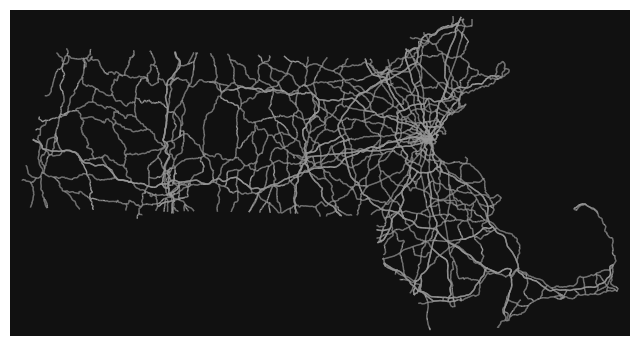

In [ ]:
fig, ax = ox.plot_graph(G, node_size=0)
plt.show()

We can try a few shortest paths by specfying the source and target nodes

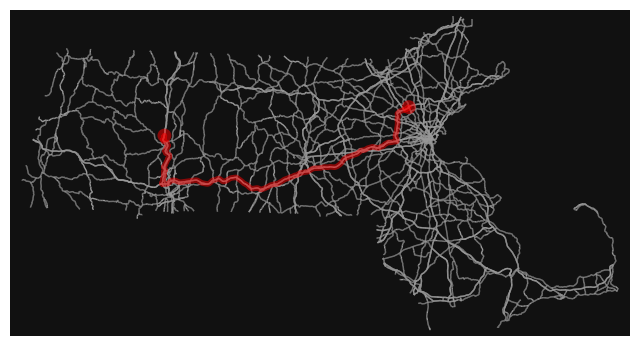

In [ ]:
# specify your source and target here
source_node = 6548
target_node = 9123

# calculate shortest path
shortest_path = nx.shortest_path(G, source_node, target_node,weight='time')

# plot the route with nodes invisible
fig, ax = ox.plot_graph_route(G, shortest_path, node_size=0)
plt.show()


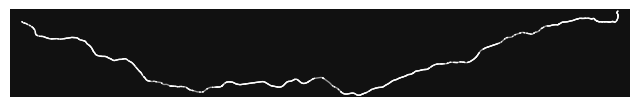

In [ ]:
# Assuming G is your graph and it has an edge attribute 'Route_ID'

# Create a list of edges where 'Route_ID' is 'I90 EB'
edges_I90_EB = [(u, v, k) for u, v, k, data in G.edges(data=True, keys=True) if data['Route_ID'] == 'I90 EB']

# Create a subgraph with these edges
G_I90_EB = G.edge_subgraph(edges_I90_EB)


# plot the route with nodes invisible
fig, ax = ox.plot_graph(G_I90_EB, node_size=1)
plt.show()

This is how we return a dataframe given the shortest path

In [ ]:
# The shortest path is a list of nodes. Create a list of edge tuples from it
#edge_list = [(shortest_path[n], shortest_path[n+1]) for n in range(len(shortest_path)-1)]

# Convert the MultiIndex to a list of tuples, and take only the first two elements of each tuple
#index_tuples = [(a, b) for a, b, _ in edges.index.to_flat_index()]

# Now use this list of tuples to create the shortest_path_edges DataFrame
#shortest_path_edges = edges[np.isin(index_tuples, edge_list)]

def shortest_path_data(shortest_path,edges):
  # Convert the shortest path to a NumPy array
  shortest_path_np = np.array(shortest_path)

  # Create an array of edge pairs
  edge_pairs_np = np.column_stack([shortest_path_np[:-1], shortest_path_np[1:]])

  # Convert the edge pairs array to a list of tuples and add the third index
  edge_list = [(*map(int, edge), 0) for edge in edge_pairs_np]

  # Add the reverse direction for each edge to the list
  edge_list += [(*map(int, edge[::-1]), 0) for edge in edge_pairs_np]

  # Get the edge pairs as a MultiIndex
  edge_pairs_index = pd.MultiIndex.from_tuples(edge_list, names=edges.index.names)

  # Now use this MultiIndex to create the shortest_path_edges DataFrame
  shortest_path_edges = edges[edges.index.isin(edge_pairs_index)]

  return edge_pairs_index,shortest_path_edges




,,,FID_1,FID_1_1,OBJECTID,Route_ID,From_Measu,To_Measure,Route_Syst,Route_Numb,Route_Dire,City,...,Urban_Type,F_F_Class,Speed_Lim,PSI,Condition,Yr_Lst_Imp,Length,geometry,time,length
Min_ID,Max_ID,,,,,,,,,,,,,,,,,,,,,,
33,34,0,17,17,17,I90 EB,53.9,54.0,I,90,EB,161,...,1,1,65,4.50,Excellent,2012,0.099798,"LINESTRING Z (-72.48865 42.16631 0.00000, -72....",5.526974,0.099798
42,43,0,22,22,21,I90 EB,49.4,49.5,I,90,EB,61,...,1,1,65,2.40,Poor,2009,0.099799,"LINESTRING Z (-72.57388 42.16902 0.00000, -72....",5.527018,0.099799
60,61,0,32,32,29,I90 EB,122.3,122.4,I,90,EB,333,...,1,1,65,3.13,Good,2012,0.100066,"LINESTRING Z (-71.28363 42.33833 0.00000, -71....",5.541797,0.100066
72,73,0,38,38,35,I90 EB,91.9,92.0,I,90,EB,17,...,1,1,65,3.54,Excellent,2014,0.099860,"LINESTRING Z (-71.82041 42.20292 0.00000, -71....",5.530420,0.099860
76,77,0,40,40,37,I90 EB,104.8,104.9,I,90,EB,139,...,1,1,65,2.74,Fair,2008,0.100172,"LINESTRING Z (-71.58712 42.24892 0.00000, -71....",5.547687,0.100172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9859,41309,0,64783,8605,7962,I95 NB,45.9,46.5,I,95,NB,155,...,1,1,55,4.50,Excellent,2017,0.006685,"LINESTRING Z (-71.25721 42.44303 0.00000, -71....",0.437550,0.006685
3485,6979,0,64816,9983,9240,I91 NB,10.8,10.9,I,91,NB,325,...,1,1,65,2.81,Fair,2015,0.009594,"LINESTRING Z (-72.64775 42.15314 0.00000, -72....",0.531349,0.009594
6916,6979,0,64817,9983,9240,I91 NB,10.8,10.9,I,91,NB,325,...,1,1,65,2.81,Fair,2015,0.000117,"LINESTRING Z (-72.64781 42.15327 0.00000, -72....",0.006470,0.000117


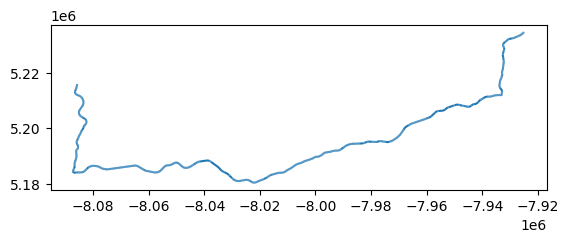

In [ ]:
edge_pairs_index,shortest_path_edges=shortest_path_data(shortest_path,edges)
shortest_path_edges.plot()
shortest_path_edges=shortest_path_edges.to_crs(4326)
shortest_path_edges

# LODES Mapping
Now, we can use the LODES and start mapping origin to destination nodes. We are going to use NodeMatch to find the near ID's and add them as columns

In [ ]:
if Load==False:
  # Merge LODES and NodeMatch
  LODES = LODES.merge(NodeMatch[['GEOID20', 'NEAR_FID', 'NEAR_DIST']], how='left', left_on='w_geocode', right_on='GEOID20')

  # Drop the 'GEOID20' column
  LODES.drop('GEOID20', axis=1, inplace=True)

  # Rename the 'NEAR_FID' and 'NEAR_DIST' columns
  LODES.rename(columns={'NEAR_FID': 'w_node', 'NEAR_DIST': 'w_dist'}, inplace=True)

  # Merge LODES and NodeMatch
  LODES = LODES.merge(NodeMatch[['GEOID20', 'NEAR_FID', 'NEAR_DIST']], how='left', left_on='h_geocode', right_on='GEOID20')

  # Drop the 'GEOID20' column
  LODES.drop('GEOID20', axis=1, inplace=True)

  # Rename the 'NEAR_FID' and 'NEAR_DIST' columns
  LODES.rename(columns={'NEAR_FID': 'h_node', 'NEAR_DIST': 'h_dist'}, inplace=True)

  # Remove rows with any NaN values
  LODES = LODES.dropna()

  # Reset index
  LODES = LODES.reset_index(drop=True)


  LODES['w_node'] = LODES['w_node'].astype(int)
  LODES['h_node'] = LODES['h_node'].astype(int)

  len1=len(LODES)
  lensame=np.sum(LODES.h_node==LODES.w_node)

  # Remove rows where 'h_node' matches 'w_node'
  LODES = LODES[LODES['h_node'] != LODES['w_node']]

  # Reset index
  LODES = LODES.reset_index(drop=True)

  unique_trips = LODES[['h_node', 'w_node']].drop_duplicates()

  # Convert DataFrame to list of tuples
  unique_trips = list(unique_trips.itertuples(index=False, name=None))

  lenall=len(unique_trips)
  with open('pickle/unique_trips.pkl', 'wb') as f:
    pickle.dump(unique_trips, f, pickle.HIGHEST_PROTOCOL)
  LODES.to_pickle('pickle/LODESMatchNode.pkl')
else:
  LODES=pd.read_pickle('pickle/LODESMatchNode.pkl')
  with open('pickle/unique_trips.pkl', 'rb') as f:
    unique_trips = pickle.load(f)

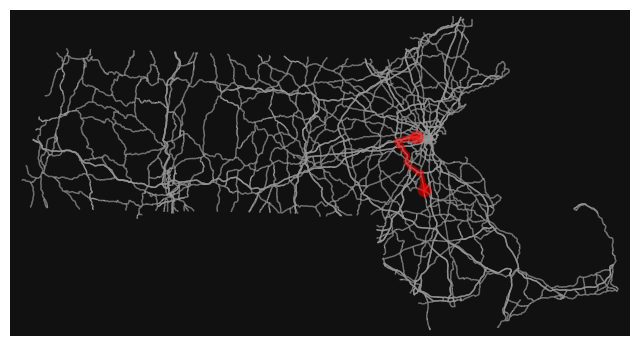

In [ ]:
  hh=LODES[(LODES.w_geocode==250250001022029) & (LODES.h_geocode==250214561022021)]['h_node'].values
  ww=LODES[(LODES.w_geocode==250250001022029) & (LODES.h_geocode==250214561022021)]['w_node'].values
  source_node = 6548
  target_node = 9123

  # calculate shortest path
  shortest_path = nx.shortest_path(G, hh[0], ww[0])

  # plot the route with nodes invisible
  fig, ax = ox.plot_graph_route(G, shortest_path, node_size=0)
  plt.show()

# Finding the shortest path
We will find the shortest path for unique trips and use that to match home and work trips

In [ ]:
no_path = 0
i_start = 0
batch_size = 10000

# Assume that unique_trips and G are defined before this point

# Try to load the last saved i_start and no_path, or initialize them if this is the first time you run the script
if os.path.exists('paths/chunks/i_start.pkl'):
    with open('paths/chunks/i_start.pkl', 'rb') as f:
        i_start = pickle.load(f)
if os.path.exists('paths/chunks/no_path.pkl'):
    with open('paths/chunks/no_path.pkl', 'rb') as g:
        no_path = pickle.load(g)

# Initialize the batches
paths_batch = []
nodes_batch = []

# Loop over unique_trips starting from i_start
for i in range(i_start, len(unique_trips)):
    try:
        # Try to calculate shortest path
        shortest_path = nx.shortest_path(G, unique_trips[i][0], unique_trips[i][1], weight='time')
    except nx.NetworkXNoPath:
        # If no path is found, set shortest_path to "no path"
        shortest_path = "no path"
        no_path += 1
        print(f"No path between {unique_trips[i][0]} and {unique_trips[i][1]}")
        print(no_path)

    # Add shortest_path and nodes to their respective batches
    paths_batch.append(shortest_path)
    nodes_batch.append(unique_trips[i])

    print(i, len(unique_trips))

    # If the batch is full or we're at the end, save the batches and clear them
    if len(paths_batch) == batch_size or i == len(unique_trips) - 1:
        with open(f'paths/chunks/path_{i//batch_size}.pkl', 'wb') as f:
            pickle.dump(paths_batch, f)
        with open(f'paths/chunks/nodes_{i//batch_size}.pkl', 'wb') as g:
            pickle.dump(nodes_batch, g)
        paths_batch = []
        nodes_batch = []

        # Save i_start and no_path
        with open('paths/chunks/i_start.pkl', 'wb') as f:
            pickle.dump(i, f)
        with open('paths/chunks/no_path.pkl', 'wb') as g:
            pickle.dump(no_path, g)


Streaming output truncated to the last 5000 lines.
644999 2609101
645000 2609101
645001 2609101
645002 2609101
645003 2609101
645004 2609101
645005 2609101
645006 2609101
645007 2609101
645008 2609101
645009 2609101
645010 2609101
645011 2609101
645012 2609101
645013 2609101
645014 2609101
645015 2609101
645016 2609101
645017 2609101
645018 2609101
645019 2609101
645020 2609101
645021 2609101
645022 2609101
645023 2609101
645024 2609101
645025 2609101
645026 2609101
645027 2609101
645028 2609101
645029 2609101
645030 2609101
645031 2609101
645032 2609101
645033 2609101
645034 2609101
645035 2609101
645036 2609101
645037 2609101
645038 2609101
645039 2609101
645040 2609101
645041 2609101
645042 2609101
645043 2609101
645044 2609101
645045 2609101
645046 2609101
645047 2609101
645048 2609101
645049 2609101
645050 2609101
645051 2609101
645052 2609101
645053 2609101
645054 2609101
645055 2609101
645056 2609101
645057 2609101
645058 2609101
645059 2609101
645060 2609101
645061 2609101
6450

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



649991 2609101
649992 2609101
649993 2609101
649994 2609101
649995 2609101
649996 2609101
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-24-2ad3c0452ae1>", line 39, in <cell line: 20>
    with open(f'paths/chunks/path_{i//batch_size}.pkl', 'wb') as f:
OSError: [Errno 107] Transport endpoint is not connected: 'paths/chunks/path_64.pkl'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'OSError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ul

# Rest is for testing

In [ ]:
#This creates the index of unique trips that match the LODES dataset. No need to run as I saved this already
if Load==False: #I created this to keep track of indices of trips in the LODES dataset, we do not need to run it normally
  # Merge LODES and NodeMatch
  LODES = LODES.merge(NodeMatch[['GEOID20', 'NEAR_FID', 'NEAR_DIST']], how='left', left_on='w_geocode', right_on='GEOID20')

  # Drop the 'GEOID20' column
  LODES.drop('GEOID20', axis=1, inplace=True)

  # Rename the 'NEAR_FID' and 'NEAR_DIST' columns
  LODES.rename(columns={'NEAR_FID': 'w_node', 'NEAR_DIST': 'w_dist'}, inplace=True)

  # Merge LODES and NodeMatch
  LODES = LODES.merge(NodeMatch[['GEOID20', 'NEAR_FID', 'NEAR_DIST']], how='left', left_on='h_geocode', right_on='GEOID20')

  # Drop the 'GEOID20' column
  LODES.drop('GEOID20', axis=1, inplace=True)

  # Rename the 'NEAR_FID' and 'NEAR_DIST' columns
  LODES.rename(columns={'NEAR_FID': 'h_node', 'NEAR_DIST': 'h_dist'}, inplace=True)

  # Remove rows with any NaN values
  LODES = LODES.dropna()

  # Reset index
  LODES = LODES.reset_index(drop=True)

  LODES['w_node'] = LODES['w_node'].astype(int)
  LODES['h_node'] = LODES['h_node'].astype(int)

  len1=len(LODES)
  lensame=np.sum(LODES.h_node==LODES.w_node)

  # Remove rows where 'h_node' matches 'w_node'
  LODES = LODES[LODES['h_node'] != LODES['w_node']]

  # Reset index
  LODES = LODES.reset_index(drop=True)

  # Initialize an empty dictionary to store trip -> indices mapping
  trip_to_indices = {}

  # Iterate over rows in LODES
  for idx, row in LODES.iterrows():
      trip = (row['h_node'], row['w_node'])

      # If trip already exists in dictionary, append index
      if trip in trip_to_indices:
          trip_to_indices[trip].append(idx)
      # If trip does not exist in dictionary, create new list with index
      else:
          trip_to_indices[trip] = [idx]

  # Create unique_trips by taking keys from the dictionary
  unique_trips = list(trip_to_indices.keys())

  #trip_indices = trip_to_indices[unique_trips[1348345]]
  with open('pickle/tripindex.pkl', 'wb') as f:
    pickle.dump(trip_to_indices, f)
else:
  # Read the dictionary from a pickle file
  with open('pickle/tripindex.pkl', 'rb') as f:
    trip_to_indices = pickle.load(f)

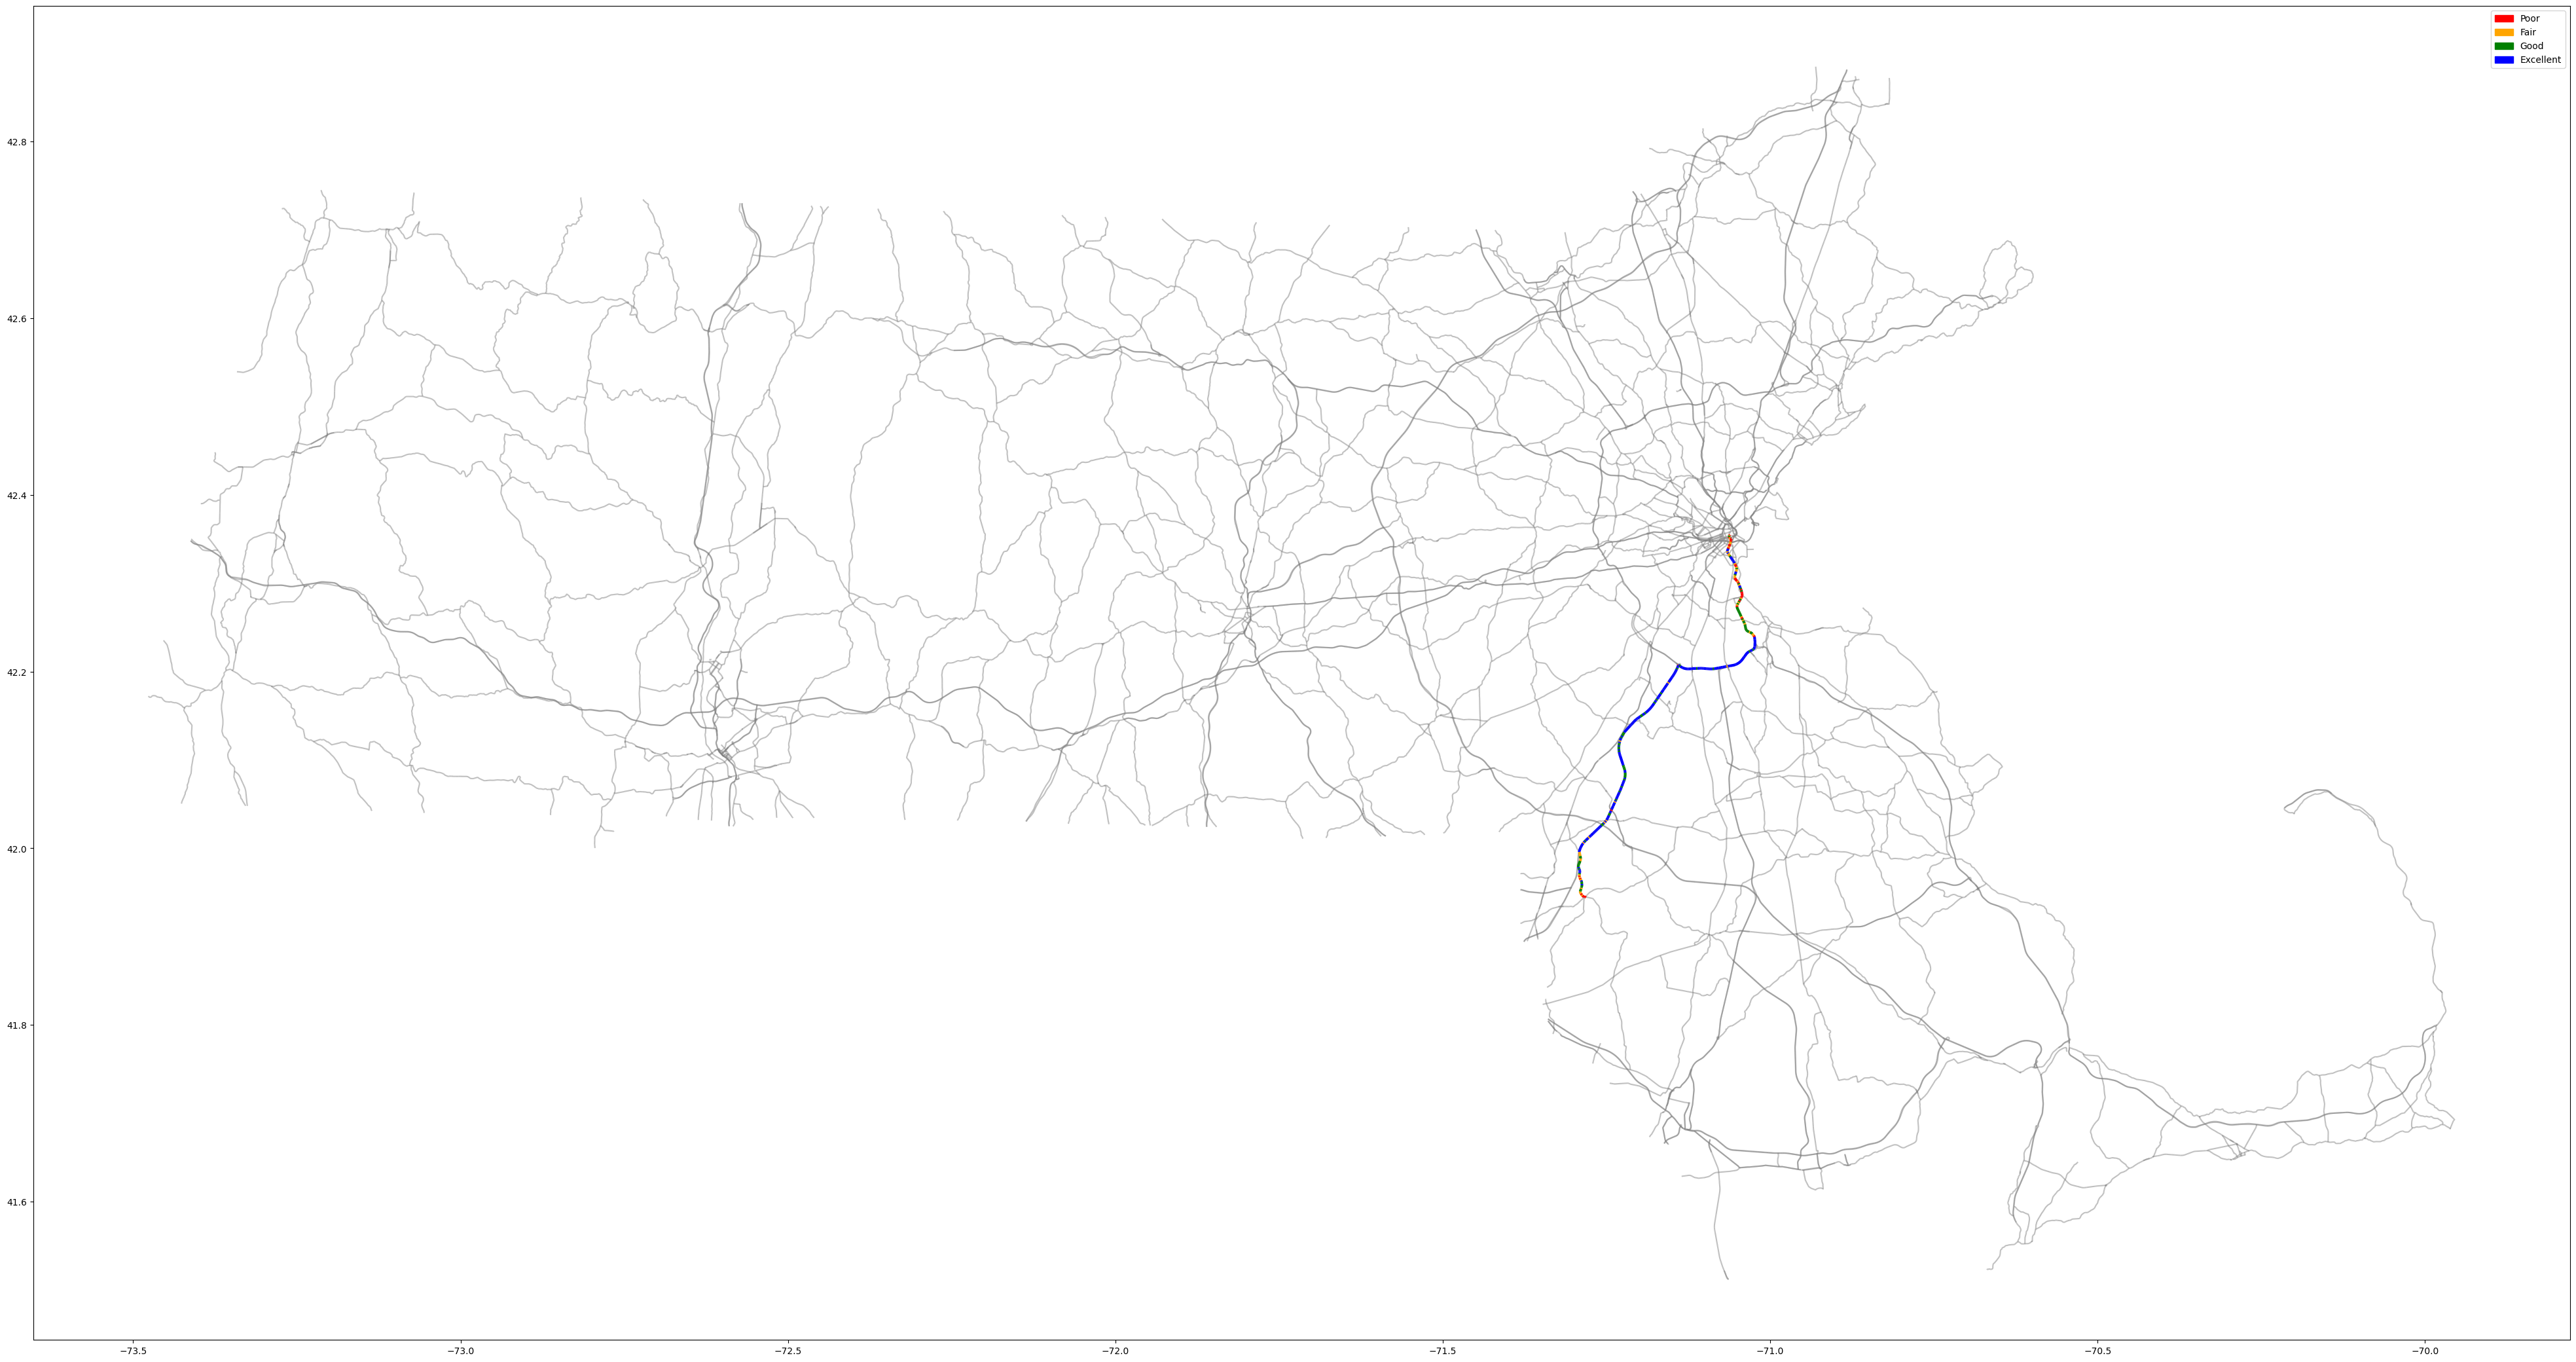

In [ ]:
from geopy.geocoders import Nominatim
from pyproj import CRS, Transformer
import matplotlib.patches as mpatches

geolocator = Nominatim(user_agent="my_Plot")
location1 = geolocator.geocode("Attleboro,MA")
location2 = geolocator.geocode("Boston,MA")

def shortest_path_data(shortest_path,edges):
  # Convert the shortest path to a NumPy array
  shortest_path_np = np.array(shortest_path)

  # Create an array of edge pairs
  edge_pairs_np = np.column_stack([shortest_path_np[:-1], shortest_path_np[1:]])

  # Convert the edge pairs array to a list of tuples and add the third index
  edge_list = [(*map(int, edge), 0) for edge in edge_pairs_np]

  # Add the reverse direction for each edge to the list
  edge_list += [(*map(int, edge[::-1]), 0) for edge in edge_pairs_np]

  # Get the edge pairs as a MultiIndex
  edge_pairs_index = pd.MultiIndex.from_tuples(edge_list, names=edges.index.names)

  # Now use this MultiIndex to create the shortest_path_edges DataFrame
  shortest_path_edges = edges[edges.index.isin(edge_pairs_index)]

  return edge_pairs_index,shortest_path_edges



def transform_coordinates(lat, lon, crs_from=4326, crs_to=3857):
    transformer = Transformer.from_crs(CRS(crs_from), CRS(crs_to))
    return transformer.transform(lat, lon)

# Transforms the coordinates of the locations to crs 3857
Origin = transform_coordinates(location1.latitude, location1.longitude)
Destination = transform_coordinates(location2.latitude, location2.longitude)

source_node = ox.nearest_nodes(G, Origin[0], Origin[1])
target_node = ox.nearest_nodes(G, Destination[0], Destination[1])


# calculate shortest path
shortest_path = nx.shortest_path(G, source_node, target_node,weight='time')
#shortest_path=ox.shortest_path(G, source_node, target_node, weight='time')
#shortest_path = next(ox.k_shortest_paths(G, source_node, target_node,k=1, weight='time'))
edge_pairs_index,shortest_path_edges=shortest_path_data(shortest_path,edges)
shortest_path_edges=shortest_path_edges.to_crs(4326)

# Calculate the total length of the route
total_length = shortest_path_edges['length'].sum()

# Group by the condition and sum the lengths
condition_lengths = shortest_path_edges.groupby('Condition')['length'].sum()

# Calculate the percentage of the total for each condition category
condition_percentages = condition_lengths / total_length * 100


# Create a color map for the conditions
colors = {'Poor': 'red', 'Fair': 'orange', 'Good': 'green', 'Excellent': 'blue'}

# Create a new column in the DataFrame that maps the condition to a color
shortest_path_edges['color'] = shortest_path_edges['Condition'].map(colors)

# Plot the roads
fig, ax = plt.subplots(figsize=(50, 50))
road.plot(ax=ax, color='gray', alpha=0.5)
shortest_path_edges.plot(ax=ax, color=shortest_path_edges['color'], linewidth=3)
#EJ.plot(ax=ax,column='EJ_CRITERI',cmap='OrRd')
# Create the legend patches
patches = [mpatches.Patch(color=color, label=condition) for condition, color in colors.items()]

# Add the legend to the plot
plt.legend(handles=patches)

plt.show()

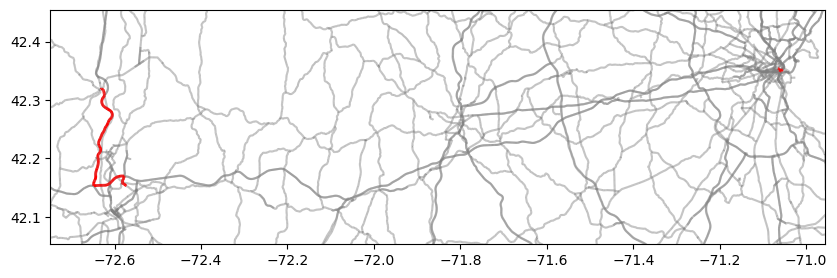

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

# Plot the roads
road.plot(ax=ax, color='gray', alpha=0.5)

# Plot the shortest path
shortest_path_edges.geometry.plot(ax=ax, color='red', linewidth=2)

# Calculate the bounds of the shortest path
minx, miny, maxx, maxy = shortest_path_edges.geometry.total_bounds

# Add some padding
padding = 0.1  # Change this value to adjust the amount of padding
ax.set_xlim(minx - padding, maxx + padding)
ax.set_ylim(miny - padding, maxy + padding)

plt.show()

In [ ]:
shortest_path_edges

,,,FID_1,FID_1_1,OBJECTID,Route_ID,From_Measu,To_Measure,Route_Syst,Route_Numb,Route_Dire,City,...,NHS,Urban_Type,F_F_Class,Speed_Lim,PSI,Condition,length,Yr_Lst_Imp,Count_,geometry
Min_Id,Max_Id,,,,,,,,,,,,,,,,,,,,,,
37643,37707,0,4,4,5,I495 NB,27.400000,27.500000,I,495,NB,218,...,1,1,1,65,3.64,Excellent,216.537048,2014,2,"LINESTRING Z (-71.16585 41.98795 0.00000, -71...."
27271,27295,0,11,11,12,I495 NB,45.700000,45.900000,I,495,NB,25,...,1,1,1,65,3.59,Excellent,434.394296,2015,2,"LINESTRING Z (-71.46428 42.11282 0.00000, -71...."
25362,25365,0,14,14,15,I495 NB,60.400000,60.500000,I,495,NB,277,...,1,1,1,65,4.50,Excellent,218.077276,2009,2,"LINESTRING Z (-71.56486 42.30301 0.00000, -71...."
57054,57056,0,23,21,22,I195 EB,39.900000,40.000000,I,195,EB,310,...,1,1,1,40,3.50,Good,51.127294,2010,2,"LINESTRING Z (-70.73217 41.78371 0.00000, -70...."
34000,34048,0,25,23,24,I495 NB,32.200000,32.300000,I,495,NB,167,...,1,1,1,65,3.44,Good,216.619081,2014,2,"LINESTRING Z (-71.24566 42.02129 0.00000, -71...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11470,11483,0,62699,61213,61515,US20 WB,83.800000,83.875591,US,20,WB,339,...,0,0,0,0,3.29,Good,163.847552,2005,2,"LINESTRING Z (-72.49607 42.14128 0.00000, -72...."
59786,59812,0,62794,61305,61607,US6 WB,56.000000,56.800000,US,6,WB,261,...,14,1,2,55,4.50,Excellent,1723.314880,2005,2,"LINESTRING Z (-70.43599 41.72581 0.00000, -70...."
59932,59939,0,62808,61318,61620,US6 WB,53.500000,53.600000,US,6,WB,20,...,14,1,2,55,3.58,Excellent,215.489920,2005,2,"LINESTRING Z (-70.39813 41.70343 0.00000, -70...."


In [ ]:
# Calculate the total length of the route
total_length = shortest_path_edges['length'].sum()

# Group by the condition and sum the lengths
condition_lengths = shortest_path_edges.groupby('Condition')['length'].sum()

# Calculate the percentage of the total for each condition category
condition_percentages = condition_lengths / total_length * 100

In [ ]:
condition_percentages

Condition
Excellent    41.685857
Fair         25.389879
Good         25.690522
Poor          7.233741
Name: length, dtype: float64

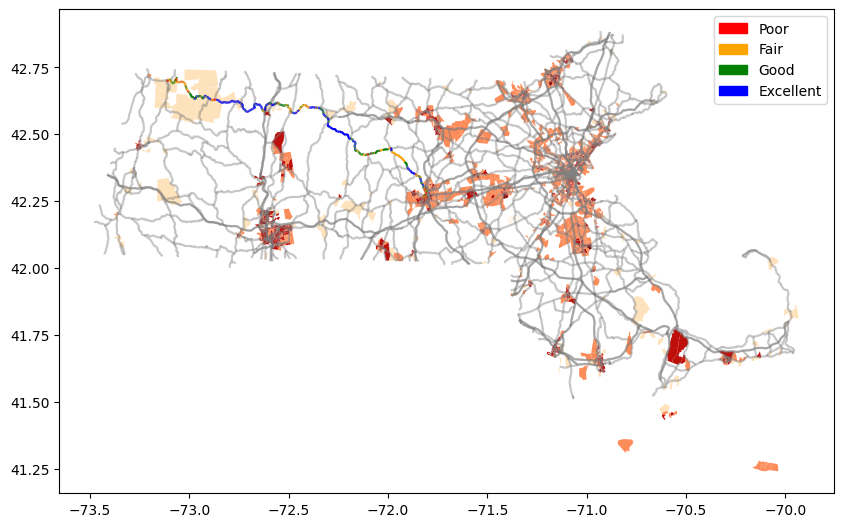

In [ ]:
import matplotlib.patches as mpatches
# Create a color map for the conditions
colors = {'Poor': 'red', 'Fair': 'orange', 'Good': 'green', 'Excellent': 'blue'}

# Create a new column in the DataFrame that maps the condition to a color
shortest_path_edges['color'] = shortest_path_edges['Condition'].map(colors)

# Plot the roads
fig, ax = plt.subplots(figsize=(10, 10))
road.plot(ax=ax, color='gray', alpha=0.5)
shortest_path_edges.plot(ax=ax, color=shortest_path_edges['color'], linewidth=1.5)
EJ.plot(ax=ax,column='EJ_CRITERI',cmap='OrRd')
# Create the legend patches
patches = [mpatches.Patch(color=color, label=condition) for condition, color in colors.items()]

# Add the legend to the plot
plt.legend(handles=patches)

plt.show()




